# Question 1

### Q1.1 使用One-hot Encoding建構資料變數。所有資料變數都要是Numpy Array。

### Solve

1. Import data

2. Find x_train, which are fold <=6

3. Separate name in x_train, eg."承恩" -> “承”,“恩”,“承恩”, no change for 單名

4. Check whether each feature appear less than 1 time, if so delete the feature.

5. Now we get the feature list, which has size 1630 -> ['_Other_Feature_' '思' '安' ... '勒' '品嘉' '芷妘']

6. Process the data into feature matrix

    1. Check whether the name is in the feature list

    2. Check whether the name has two characters, if so check both of them, whether they are in feature matrix.

    3. If one condition didn't fulfill, set first column to 1, which is '_Other_Featuer_' = 1

7. Then check its fold, put it to the right subset.

In [86]:
# import data
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

In [87]:
raw_x_train = []

# get x_train
# separate name, aka "你好" -> "你","好","你好"
for sex,name,fold in zip(sexlist, namelist, foldlist):
    if fold <= 6:
        raw_x_train.append(name)
        if(len(name)!=1):
            raw_x_train.append(name[0])
            raw_x_train.append(name[1])


# Get feature list from training data (x_train), which are features that appear more than once
# If a feature appears only once, it will be replaced by '_Other_Feature_'
feature_list = pd.DataFrame(raw_x_train, columns=['name'])
name_counts = feature_list['name'].value_counts()
# Set feature that appears only once to '_Other_Feature_'
feature_list['name'] = feature_list['name'].apply(lambda raw_x: '_Other_Feature_' if name_counts[raw_x] < 2 else raw_x)
feature_list.drop_duplicates(subset=['name'], keep='first', inplace=True)
feature_list = np.array(feature_list.values.tolist()).reshape(-1)
feature_cnt = len(feature_list)

print(feature_cnt)
print(feature_list)

1630
['_Other_Feature_' '思' '安' ... '勒' '品嘉' '芷妘']


In [88]:
# Process the original rawdata, convert it into feature vectors
def to1hot(rawx, rawy):
    x = []
    y = []
    for i in range(len(rawx)):
        new_arr = np.zeros(feature_cnt)
        fullnamepos = np.where(feature_list == rawx[i])

        # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
        if fullnamepos[0].size == 0:
            new_arr[0] = 1
        else:
            new_arr[fullnamepos[0]] = 1

        if len(rawx[i]) == 2:
            separatenamepos1 = np.where(feature_list == rawx[i][0])
            separatenamepos2 = np.where(feature_list == rawx[i][1])

            # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
            if separatenamepos1[0].size == 0:
                new_arr[0] = 1
            else:
                new_arr[separatenamepos1[0]] = 1
                
            # if can't find the feature in feature_list, set '_Other_Feature_' feature to 1
            if separatenamepos2[0].size == 0:
                new_arr[0] = 1
            else:
                new_arr[separatenamepos2[0]] = 1
                
        x.append(new_arr)
        y.append(rawy[i])
    return np.asarray(x), np.asarray(y)

In [89]:
# empty the original rawdata, since we don't need separate name anymore, we only need to check the fold.
raw_x_train = []
raw_y_train = []
raw_x_valid = []
raw_y_valid = []
raw_x_stack = []
raw_y_stack = []
raw_x_test = []
raw_y_test = []

# Set the fold 0-6 as training data, 7 as validation data, 8 as stack data, 9 as test data
for sex,name,fold in zip(sexlist, namelist, foldlist):
    if fold <= 6:
        raw_x_train.append(name)
        raw_y_train.append(sex)
    if fold == 7:
        raw_x_valid.append(name)
        raw_y_valid.append(sex)
    if fold == 8:
        raw_x_stack.append(name)
        raw_y_stack.append(sex) 
    if fold == 9:
        raw_x_test.append(name)
        raw_y_test.append(sex)

# Convert the rawdata into feature vectors
x_train, y_train = to1hot(raw_x_train, raw_y_train)
x_test, y_test = to1hot(raw_x_test, raw_y_test)
x_valid, y_valid = to1hot(raw_x_valid, raw_y_valid)
x_stack, y_stack = to1hot(raw_x_stack, raw_y_stack)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape, x_stack.shape, y_stack.shape

((7483, 1630),
 (7483,),
 (1064, 1630),
 (1064,),
 (1110, 1630),
 (1110,),
 (1073, 1630),
 (1073,))

Then we can see: train has 7483 data, test has 1064, valid has 1110, stack has 1073

### Q1.2 使用`sklearn.linear_model.LogisticRegression()`建構Logistic Regression分類模型

### Solve 

Since Grid Search的小值為$10^{-4}$，最大值是$1,000$，總共取20個點，使用等比級數間隔。

First, get grid search list, which are the regulaization coeff we want to try.

Use `np.geomspace(1e-4, 1e3, num=20)` to get the list.

Then try every coeff in the list, find the best model which has best f1


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

In [91]:
# 定義Grid Search範圍，取20個點，使用等比級數間隔
# 1m40s

# Grid Search
c_values = np.geomspace(1e-4, 1e3, num=20)
best_f1 = -1
best_c = -1
bestmodel = None

for c in c_values:
    model = LogisticRegression(C=c, max_iter=10000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_c = c
        bestmodel = model


print("Best Regularization Coefficient (bestc):", best_c)
print("Best F1 Score:", best_f1)
print("Best Model:", bestmodel)


Best Regularization Coefficient (bestc): 78.47599703514607
Best F1 Score: 0.8981132075471698
Best Model: LogisticRegression(C=78.47599703514607, max_iter=10000)


We can see, the best c is 78.48, which has f1 = 0.9

Now we combine training and validation to create new data set, train the best model again.

In [92]:
# Get new data by combining training data and validation data
x_trainandvalid = np.concatenate((x_train, x_valid), axis=0)
y_trainandvalid = np.concatenate((y_train, y_valid), axis=0)

# Train the model with best regularization coefficient
BestLogisticModel = LogisticRegression(C=best_c, max_iter=10000)
BestLogisticModel.fit(x_trainandvalid, y_trainandvalid)
Log_y_pred = BestLogisticModel.predict(x_test)

# Get the f1, accuracy, precision, recall of the model
f1 = f1_score(y_test, Log_y_pred)
acc = BestLogisticModel.score(x_test, y_test)
precision = precision_score(y_test, Log_y_pred)
recall = recall_score(y_test, Log_y_pred)

# Get the top 20 features
coef = np.abs(BestLogisticModel.coef_)
coef = coef.flatten()
sorted_indices = np.argsort(coef)[::-1]
top_20_values = sorted_indices[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]


print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8761329305135951
Test Accuracy: 0.8843984962406015
Test Precision: 0.8596837944664032
Test Recall: 0.893223819301848
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['傑', '森', '玲', '雯', '凌', '婷', '美', '萱', '鋒', '薇', '妤', '婕', '綾', '潔', '嵐', '絃', '卉', '靜', '松', '蓉']


### Q1.3 使用`sklearn.ensemble.RandomForestClassifier()`建構Random Forest分類模型

Do things similar to the previous problem, except with different model

In [93]:
from sklearn.ensemble import RandomForestClassifier

# 10-15 min

# Grid Search
n_estimator = np.geomspace(5, 1000, num=10, dtype=int)

best_f1 = -1
best_nest = -1
bestmodel = None

for n in n_estimator:
    rf_model = RandomForestClassifier(n_estimators=n)
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_valid)
    f1 = f1_score(y_valid, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_nest = n
        bestmodel = rf_model

print("Best Number of Trees (i.e., n_estimators):", best_nest)
print("Best F1 Score:", best_f1)
print("Best Model:", bestmodel)

Best Number of Trees (i.e., n_estimators): 308
Best F1 Score: 0.8673076923076922
Best Model: RandomForestClassifier(n_estimators=308)


We can see the best number of trees is 9, which has F1 score of 0.88

Now we train a new model with that number of tree and concatenated data set.

In [94]:
# Train best model with best number of trees
BestRandomForestModel = RandomForestClassifier(n_estimators=best_nest)
# Use training data and validation data to train the model
BestRandomForestModel.fit(x_trainandvalid, y_trainandvalid)
RF_y_pred = BestRandomForestModel.predict(x_test)

In [95]:
# Get the f1, accuracy, precision, recall of the model
f1 = f1_score(y_test, RF_y_pred)
acc = BestRandomForestModel.score(x_test, y_test)
precision = precision_score(y_test, RF_y_pred)
recall = recall_score(y_test, RF_y_pred)

# Get the top 20 features
feature_importances = BestRandomForestModel.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_20_importances = feature_importances[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_list[i] for i in top_20_indices]

print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8321608040201005
Test Accuracy: 0.8430451127819549
Test Precision: 0.8149606299212598
Test Recall: 0.8501026694045175
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['妤', '翔', '萱', '柏', '婷', '怡', '蓁', '哲', '承', '雅', '佳', '柔', '芷', '晴', '芸', '宜', '瑄', '庭', '_Other_Feature_', '涵']


### Q1.4 使用`sklearn.ensemble.GradientBoostingClassifier()`建構Gradient Boosting Decision Tree (GBDT)分類模型

### Solve

There are two parameters to worry about, which are learning rate and n_estimator.

Since for GBDT model, we can see the result of all estimators with less than the max estimator value.

We only need to set `n_estimators=1500` to do the job, then check every learning rate.

After training each model with 1500 estimators, we iterate through count of estimators and check it's f1_score with `for stage, predictions in enumerate(gbdt.staged_predict(x_valid)):`

Then after getting the best f1 and lr, we train again with concatenated data set.

In [96]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 1500
learning_rates = [.1, .5, 1]
f1_scores = []
best_lr = -1
best_nstg = -1
bestf1 = -1


for learning_rate in learning_rates:
    f1_scores_this_rnd = []
    gbdt = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    gbdt.fit(x_train, y_train)

    # Get the f1 score of each stage
    for stage, predictions in enumerate(gbdt.staged_predict(x_valid)):
        f1 = f1_score(y_valid, predictions)
        f1_scores_this_rnd.append(f1)
        if best_f1 < f1:
            best_f1 = f1
            best_lr = learning_rate
            best_nstg = stage
    f1_scores.append(f1_scores_this_rnd)


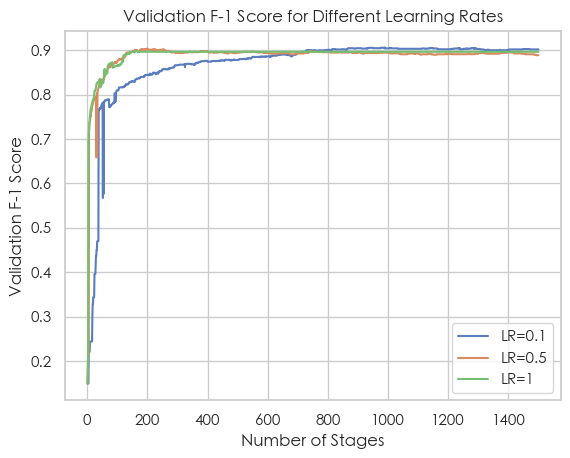

Best Learning Rate (best_lr): 0.1
Best Number of Stages (best_nstg): 988


In [97]:
# Plot the F-1 scores for different learning rates
plt.figure()
for i, lr in enumerate(learning_rates):
    plt.plot(range(1,n_estimators+1), f1_scores[i], label=f'LR={lr}')
plt.xlabel('Number of Stages')
plt.ylabel('Validation F-1 Score')
plt.legend()
plt.title('Validation F-1 Score for Different Learning Rates')
plt.show()

print("Best Learning Rate (best_lr):", best_lr)
print("Best Number of Stages (best_nstg):", best_nstg)

In [98]:
BestGBDTModel = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_nstg)
BestGBDTModel.fit(x_trainandvalid, y_trainandvalid)
GBDT_y_pred = BestGBDTModel.predict(x_test)

In [99]:
from sklearn.metrics import accuracy_score

f1 = f1_score(y_test, GBDT_y_pred)
acc = accuracy_score(y_test, GBDT_y_pred)
precision = precision_score(y_test, GBDT_y_pred)
recall = recall_score(y_test, GBDT_y_pred)

sorted_indices = np.argsort(feature_importances)[::-1]
top_20_importances = feature_importances[sorted_indices[:20]]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_list[i] for i in top_20_indices]


print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Top 20 Features index:", top_20_values.tolist())
print("Top 20 Features' Names:", feature_list[top_20_indices].tolist())

Test F1 Score: 0.8644400785854617
Test Accuracy: 0.8703007518796992
Test Precision: 0.8286252354048964
Test Recall: 0.9034907597535934
Top 20 Features index: [583, 1251, 1588, 834, 242, 1284, 31, 844, 1170, 463, 1480, 92, 527, 522, 1365, 704, 25, 803, 1133, 377]
Top 20 Features' Names: ['妤', '翔', '萱', '柏', '婷', '怡', '蓁', '哲', '承', '雅', '佳', '柔', '芷', '晴', '芸', '宜', '瑄', '庭', '_Other_Feature_', '涵']


### Q1.5 組合(Stacking)成一個新的分類器

### Solve

Get probability after predicting male (sex = 1) for each models.

Then concatenate into a new data set, and start training.

In [100]:
Log_y_pred_stack = BestLogisticModel.predict_proba(x_stack)[:,1]
RF_y_pred_stack = BestRandomForestModel.predict_proba(x_stack)[:,1]
GBDT_y_pred_stack = BestGBDTModel.predict_proba(x_stack)[:,1]
processed_x_stack = np.concatenate((Log_y_pred_stack.reshape(-1,1), RF_y_pred_stack.reshape(-1,1), GBDT_y_pred_stack.reshape(-1,1)), axis=1)

LosgisticStackModel = LogisticRegression(max_iter=10000, penalty=None)
LosgisticStackModel.fit(processed_x_stack, y_stack)


LogisticRegression(max_iter=10000, penalty=None)

In [101]:
Log_y_pred_test = BestLogisticModel.predict_proba(x_test)[:,1]
RF_y_pred_test = BestRandomForestModel.predict_proba(x_test)[:,1]
GBDT_y_pred_test = BestGBDTModel.predict_proba(x_test)[:,1]
processed_x_test = np.concatenate((Log_y_pred_test.reshape(-1,1), RF_y_pred_test.reshape(-1,1), GBDT_y_pred_test.reshape(-1,1)), axis=1)

# print(processed_x_stack)
y_pred = LosgisticStackModel.predict(processed_x_test)
f1 = f1_score(y_test, y_pred)
acc = LosgisticStackModel.score(processed_x_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Test F1 Score:", f1)
print("Test Accuracy:", acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Coefficientes:", LosgisticStackModel.coef_)

Test F1 Score: 0.875751503006012
Test Accuracy: 0.8834586466165414
Test Precision: 0.8551859099804305
Test Recall: 0.8973305954825462
Coefficientes: [[3.09880419 0.11386465 4.72575719]]


We can see that the result of this model is pretty good.

The weight for logistic regression is 3.06, Random Forest is 0.36, GBDT is 4.6

We can see that if GBDT has highest value, meaning among the three models, it's the one who mostly predicts the best.

Then for logistic regression, it has the second highest value, it's also a pretty good model as well.

However, for Random Forest has the lowest of three, meaning the value of it doesn't affect much for the whole model.

# Question 2

### Q2.1 Visualize academic departments using the first eight principal components.

Import the data and use preprocessed data from the original jupyter notebook.

And I set the department-applicant matrix into `data` because it's easiler to remember.

In [102]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['font.family'] = 'STHeiti'


stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))
#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]


#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

data = dep_stu2
data.shape

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


(1917, 47386)

This is for later use, for painting the dots to the corresponding category.

Alse a dictionary that is id of department to chinese abbriviation of the department.

In [103]:
dep_to_category = {id: name for id, name in zip(uname['department_id'], uname['category_id'])}
colors = {'1':"blue", '2':"red" ,'3':"green", '4':"orange", '5':"purple", '6':"yellow", '7':"gray", '8':"pink", '9':"cyan", '10':"black", '99':"brown"}
category_to_name = {id: name for id, name in zip(uname['category_id'], uname['category_name'])}
idtocolor = [colors[dep_to_category[x]] for x in rowname]
clr = [colors[dep_to_category[x]] for x in rowname]
comb_dep_name_abbr = [str1 + str2 for str1, str2 in zip(uname['school_name_abbr'], uname['department_name_abbr'])]
comb_dep_name_abbr_dict = {id: name for id, name in zip(uname['department_id'], comb_dep_name_abbr)}

Now we do PCA on data, and set `n_components` to 8, since we need 8 of these.

Then feed `data` into it and fit.

In [104]:
from sklearn.decomposition import PCA

n_components = 8  # You can adjust this value
pca = PCA(n_components=n_components)

# Fit the PCA model to your data and transform it
dep_stu2_pca = pca.fit_transform(data)


Now we plot the figures for each principal elements.

The ones on the top are the raw variance data, the ones on the bottom are the ones with ratio of every PA.

Explained variance by each component: [0.005, 0.0046, 0.004, 0.004, 0.0033, 0.0032, 0.0031, 0.003]
Cumulative explained variance: [0.005, 0.0096, 0.0136, 0.0176, 0.021, 0.0241, 0.0273, 0.0303]


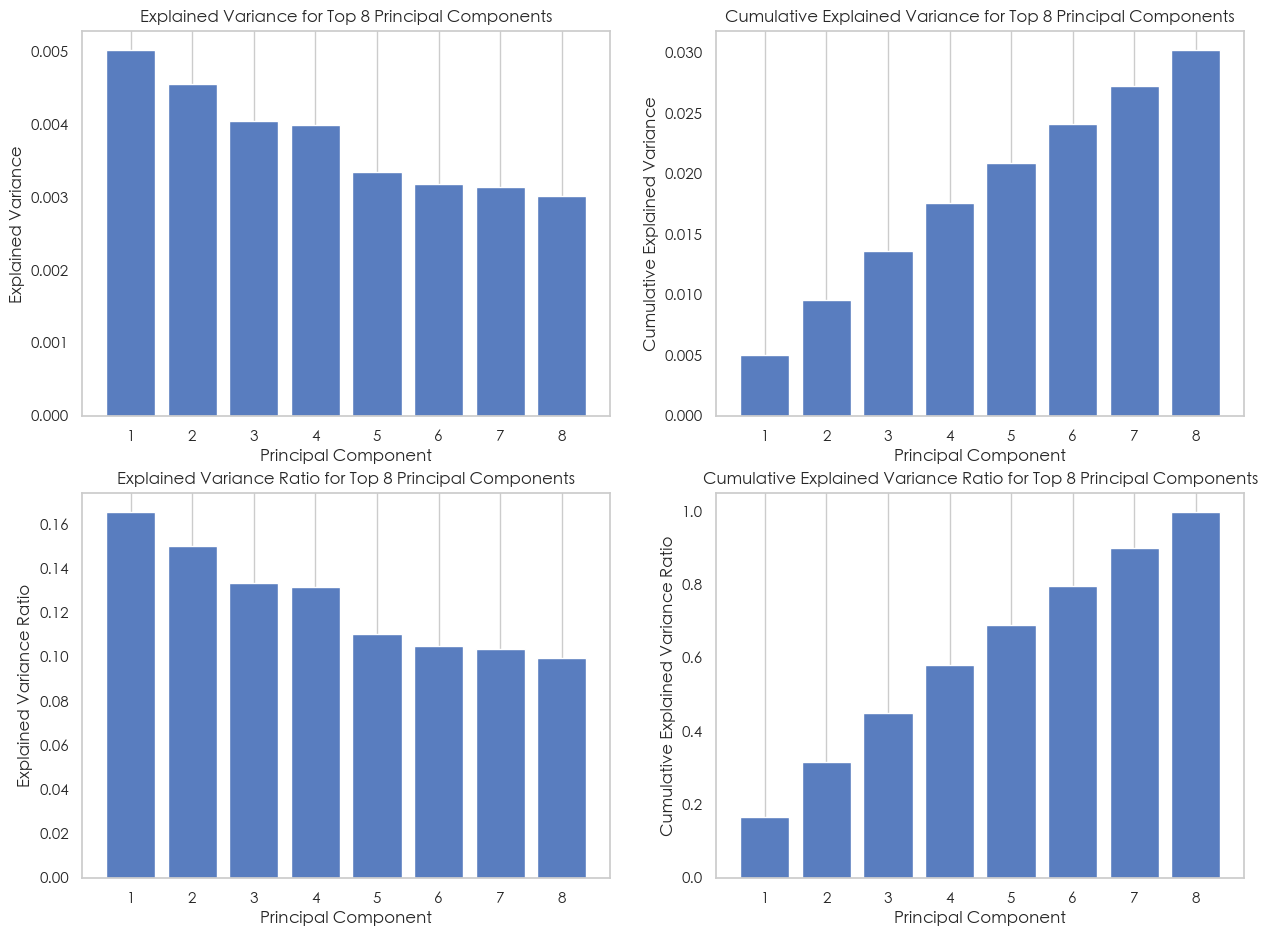

In [105]:
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", [round(x,4) for x in explained_variance.tolist()])
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative explained variance:", [round(x,4) for x in cumulative_explained_variance.tolist()])

# Create a bar chart for the top 8 principal components with department names as x-axis labels

plt.figure(figsize=(15, 11))
plt.subplot(221)
plt.bar(range(1, n_components + 1), explained_variance[:n_components], align='center')
plt.xticks(np.arange(1, n_components + 1))
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance for Top 8 Principal Components")
plt.grid(axis='y')

plt.subplot(222)
plt.bar(range(1, n_components + 1), cumulative_explained_variance[:n_components], align='center')
plt.xticks(np.arange(1, n_components + 1))
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance for Top 8 Principal Components")
plt.grid(axis='y')

plt.subplot(223)
plt.bar(range(1, n_components + 1), explained_variance[:n_components]/sum(explained_variance), align='center')
plt.xticks(np.arange(1, n_components + 1))
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio for Top 8 Principal Components")
plt.grid(axis='y')

plt.subplot(224)
plt.bar(range(1, n_components + 1), cumulative_explained_variance[:n_components]/sum(explained_variance), align='center')
plt.xticks(np.arange(1, n_components + 1))
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio for Top 8 Principal Components")
plt.grid(axis='y')


plt.show()


First, we can see for each PA, their value are pretty much the same, they have 16%-12% fo the whole variance.

Therefore, we know that there are no domain axis, all PA contribute samely to the dataset.

Now we check the values on each axis of PA, we check (1,2), (3,4)..(7,8), the color are done by the cell under preprocessing.

Text(0.5, 1.0, 'PC7 vs PC8')

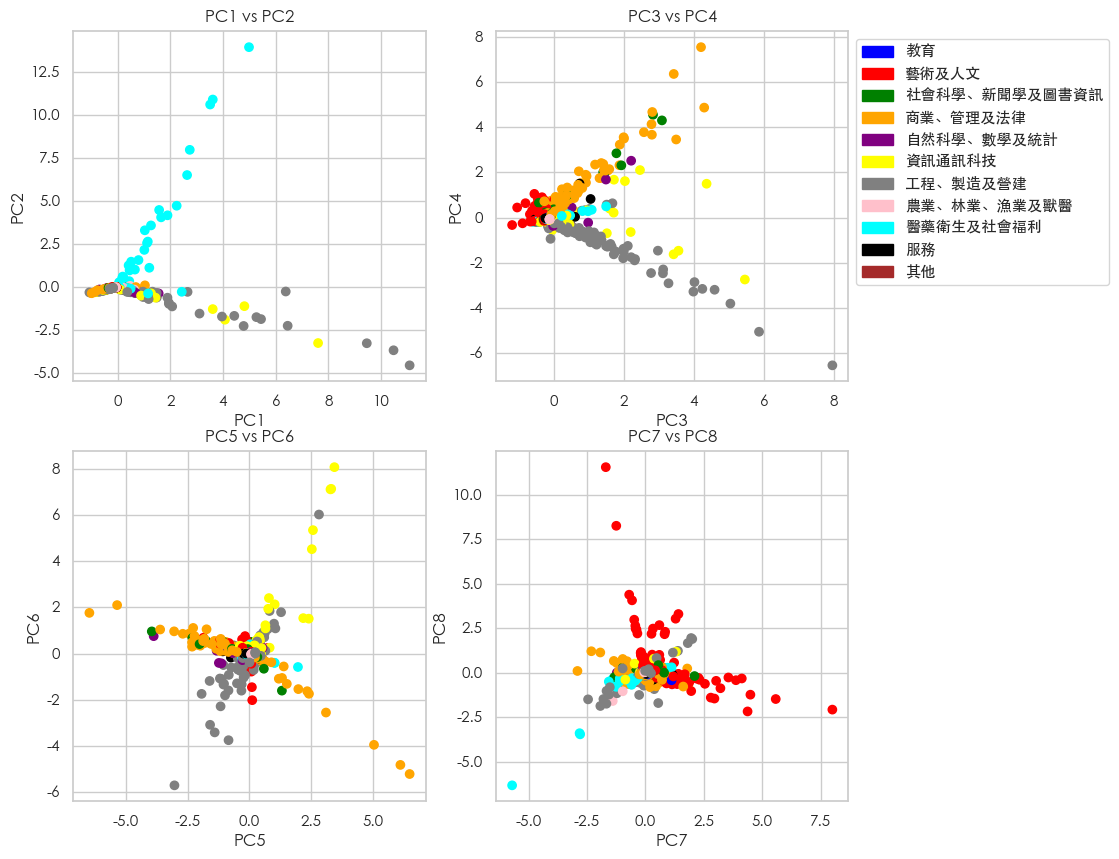

In [106]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.scatter(dep_stu2_pca[:, 0], dep_stu2_pca[:, 1], color = clr)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")

plt.subplot(222)
plt.scatter(dep_stu2_pca[:, 2], dep_stu2_pca[:, 3], color = clr)
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("PC3 vs PC4")

legend_labels = []
# Visualize the results
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(223)
plt.scatter(dep_stu2_pca[:, 4], dep_stu2_pca[:, 5], color = clr)
plt.xlabel("PC5")
plt.ylabel("PC6")
plt.title("PC5 vs PC6")

plt.subplot(224)
plt.scatter(dep_stu2_pca[:, 6], dep_stu2_pca[:, 7], color = clr)
plt.xlabel("PC7")
plt.ylabel("PC8")
plt.title("PC7 vs PC8")

1. 商業、社會科學科系在PC3、PC4 

2. 醫療相關科系集中在PC2

3. 藝術相關科系集中在PC7、PC8

4. 資訊科系集中在PC1、PC3

5. 工程科系在PC1, PC3, PC5 都可以看到他

工程和資訊有還蠻大的相關性的，很常出現在同個PA上

### Q2.2 Visualize academic departments using multiple dimensional scaling.

We need to get the dissimilarity matrix first, at first I tried euclidean distance, but it didn't work out well.

Then I tried Manhattan, Minkowski, Cosine Sim, Hamming, Jaccard all of them didn't work out well. 

But, since euclidean distance is the most commonly used, I use euclidean in this case.

As we can see I let the dissimilarity matrix to be max_distance - euclidean_distances, since if I didn't do this, the plot would be a line filled with dots.

Then we put the dissimilarity matrix into MDS and fit, we can see the result.

/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


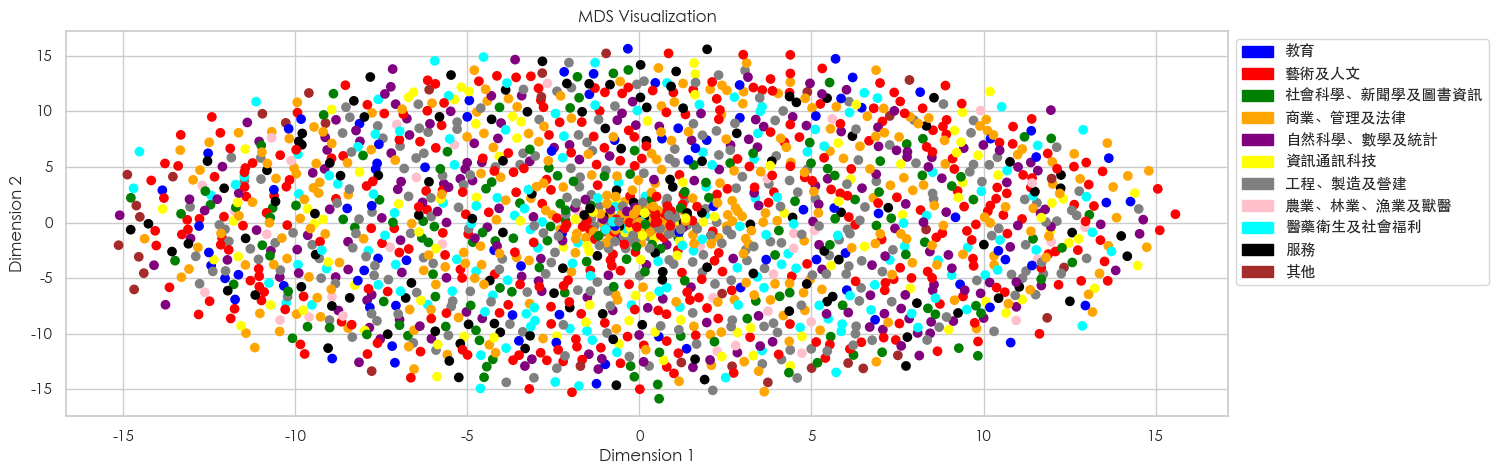

In [107]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances


euclidean_distances = pairwise_distances(data, metric='euclidean')
# if I didn't do this, the outcome would be a straight line
max_distance = euclidean_distances.max()
dissimilarity_matrix = max_distance - euclidean_distances

# MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
embedded_data = mds.fit_transform(dissimilarity_matrix)

# color
legend_labels = []
plt.figure(figsize=(15, 5))
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

# Plot the embedded data
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], color=clr)
plt.title('MDS Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


As I said, I tried different ways of calculating the distance, however everyone of them would become a mess like this.

Every point is crowded together, we can't see any groups or features. The result is not as good as PCA. 

To do non metric MDS, we set `metric = False` to yield the result.

/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


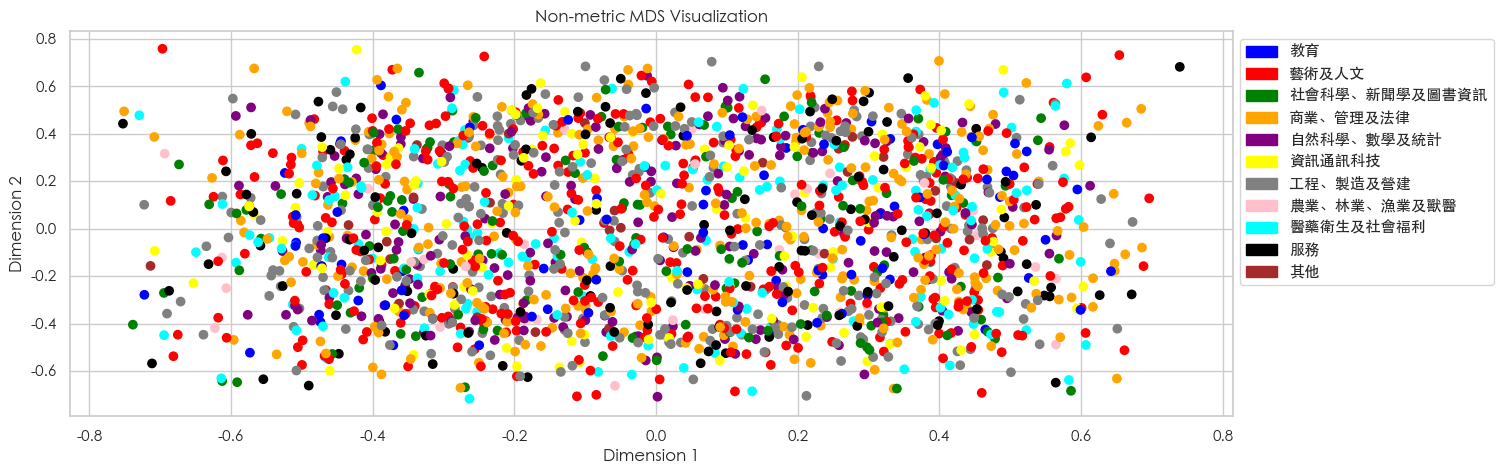

In [108]:
mds = MDS(n_components=2, dissimilarity='precomputed', metric=False, random_state=0)
embedded_data_nonmetric = mds.fit_transform(dissimilarity_matrix)

# color
legend_labels = []
# Visualize the results
plt.figure(figsize=(15, 5))
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
# Plot the embedded data
plt.scatter(embedded_data_nonmetric[:, 0], embedded_data_nonmetric[:, 1], color=clr)
plt.title('Non-metric MDS Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

When we use Non-metric MDS the result is the same as well, the department which should be the same are away frome each other. 

The plot is not good at getting any feature.

### Q2.3 Visualize academic departments using Locally Linear Embedding.

3 senarios to be concern

1. Use 20 neighbors to construct the weight matrix:

    `LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='standard')` setting n_neighbors to 20 would do the work. 

    Then set n_components=2 to get a 2d graph




2. Use 40 neighbors to construct the weight matrix;

    Set n_neighbors = 40



3. Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors)

    First, we do PCA transformation, we are getting first 100 PC, so we set `PCA(n_components=n_pca_components)` to be 100.

    Then we do fitting to get the proceessed data.

    Lastly, we put the data into LLE to yield the result.


In [109]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA


# Variation 1: LLE with 20 neighbors
lle_1 = LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='standard')
lle_result_1 = lle_1.fit_transform(data)

# Variation 2: LLE with 40 neighbors
lle_2 = LocallyLinearEmbedding(n_neighbors=40, n_components=2, method='standard')
lle_result_2 = lle_2.fit_transform(data)

# Variation 3: PCA preprocessing followed by LLE with 20 neighbors
n_pca_components = 100
pca = PCA(n_components=n_pca_components)
data_pca = pca.fit_transform(data)
lle_3 = LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='standard')
lle_result_3 = lle_3.fit_transform(data_pca)

Text(0.5, 1.0, 'PCA + LLE (20 neighbors)')

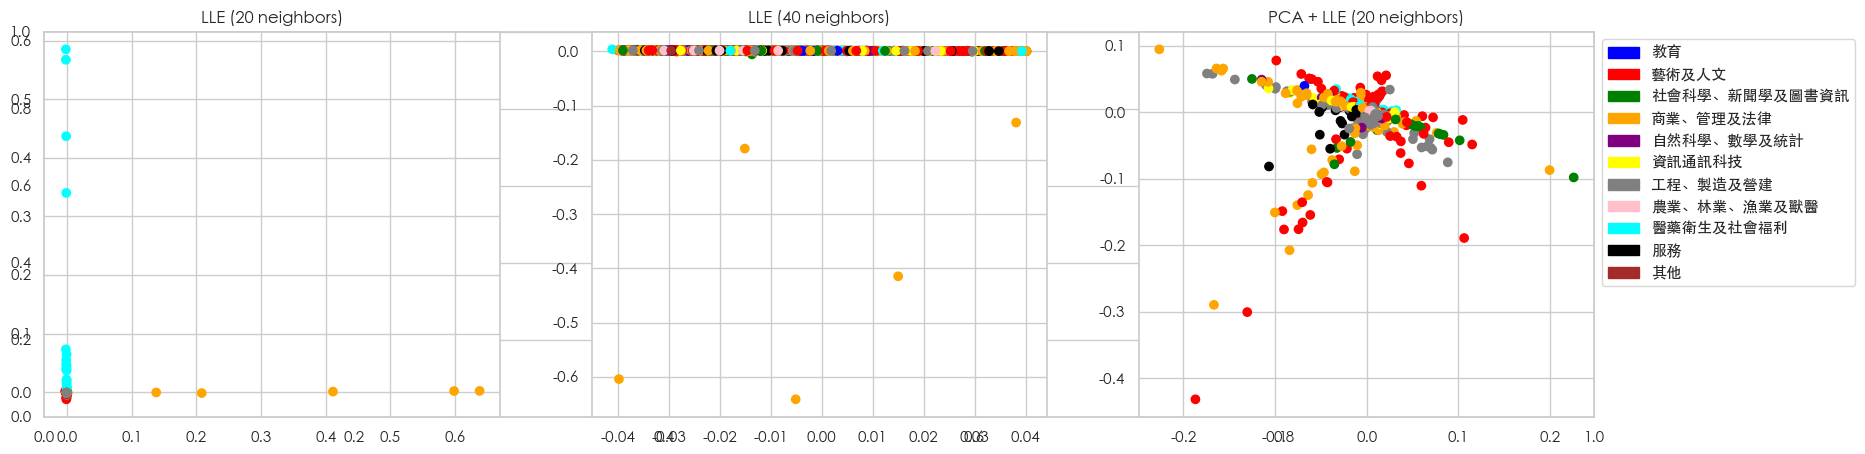

In [110]:
legend_labels = []
# Visualize the results
plt.figure(figsize=(20, 5))
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(131)
plt.scatter(lle_result_1[:, 0], lle_result_1[:, 1], c = clr)
plt.title("LLE (20 neighbors)")

plt.subplot(132)
plt.scatter(lle_result_2[:, 0], lle_result_2[:, 1], c = clr)
plt.title("LLE (40 neighbors)")

plt.subplot(133)
plt.scatter(lle_result_3[:, 0], lle_result_3[:, 1], c = clr)
plt.title("PCA + LLE (20 neighbors)")

As we can see, the first two methods didn't turn out well, only 醫藥 and 商業管理法律 stand out.

However, when we do PCA beforehand, we would get a graph where the features are grouped on different directions.

For 服務 departments the data points becomes a line that has slope = -1

藝術與人文、商業管理法律 are on the x-axis

工程製造及營運、自然科學數學統計、資訊科技 are on the y-axis

We can clearly see that 理工科系 are being grouped together, and 藝術+管理科系 are grouped together as well.


### Q2.4 Visualize academic departments using Kernel PCA.

Use `sklearn.decomposition.KernelPCA` for the task.

Set kernel = "rbf" and "cosine" to get the result.

The gamma value has been adjusted from 100000-0.0000001 and the value currently use is the best I find.

It is the most separated plot I can find. 

In [111]:
from sklearn.decomposition import KernelPCA

# Variation 1: Kernel PCA with RBF kernel
rbf_kernel_pca = KernelPCA(kernel="rbf", gamma=0.0009)
data_rbf_pca = rbf_kernel_pca.fit_transform(data)

# Variation 2: Kernel PCA with Cosine kernel
cosine_kernel_pca = KernelPCA(kernel="cosine", gamma=0.0001)
data_cosine_pca = cosine_kernel_pca.fit_transform(data)

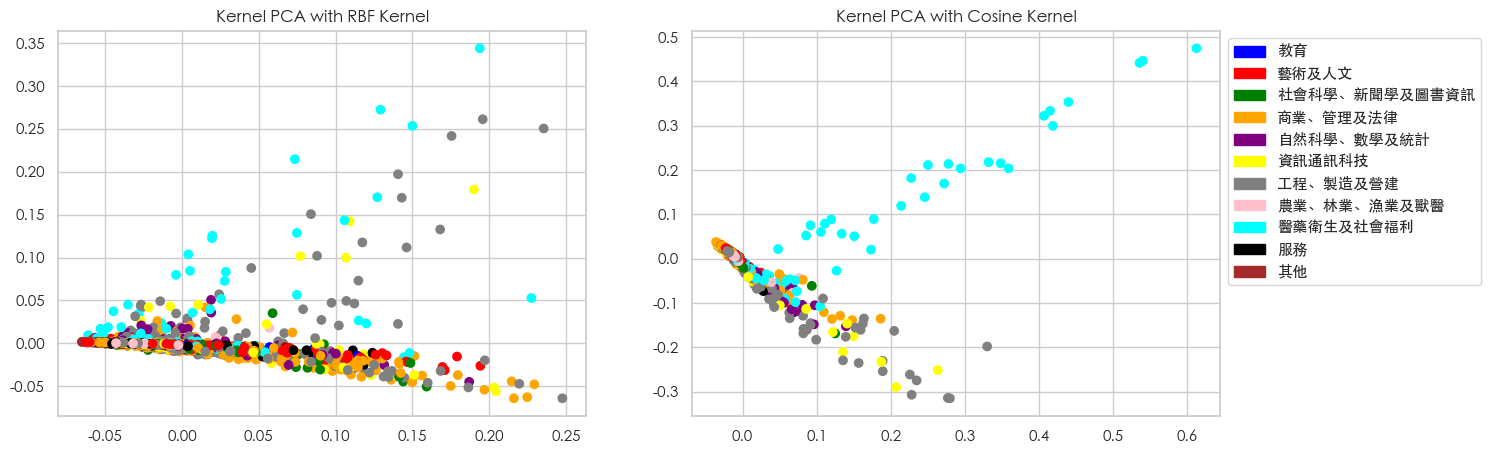

In [112]:
legend_labels = []
# Visualize the results
plt.figure(figsize=(15, 5))
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
# Visualize the results
plt.subplot(121)
plt.scatter(data_rbf_pca[:, 0], data_rbf_pca[:, 1], color = clr)
plt.title("Kernel PCA with RBF Kernel")

plt.subplot(122)
plt.scatter(data_cosine_pca[:, 0], data_cosine_pca[:, 1], color = clr)
plt.title("Kernel PCA with Cosine Kernel")

plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

The result for RBF kernel is not really bad, we can see some data points stand out such as 醫藥衛生 and 工程製造, but the rest are crowded together.

The result for PCA kernel is pretty much the same as RBF kernel, those three value stands out, and rest of the department's data points are crowded together.

### Q2.5 Visualize academic departments using t-SNE.

In [113]:
from sklearn.manifold import TSNE

# Euclidean distance
tsne_euclidean = TSNE(n_components=2, metric='euclidean', random_state=42)
embedded_data_tsne_euclidean = tsne_euclidean.fit_transform(data)

# Cosine similarity
tsne_cosine = TSNE(n_components=2, metric='cosine', random_state=42)
embedded_data_tsne_cosine = tsne_cosine.fit_transform(data)

# Jaccard distance (assuming 'data' is binary)
tsne_jaccard = TSNE(n_components=2, metric='jaccard', random_state=42)
embedded_data_tsne_jaccard = tsne_jaccard.fit_transform(data)


/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


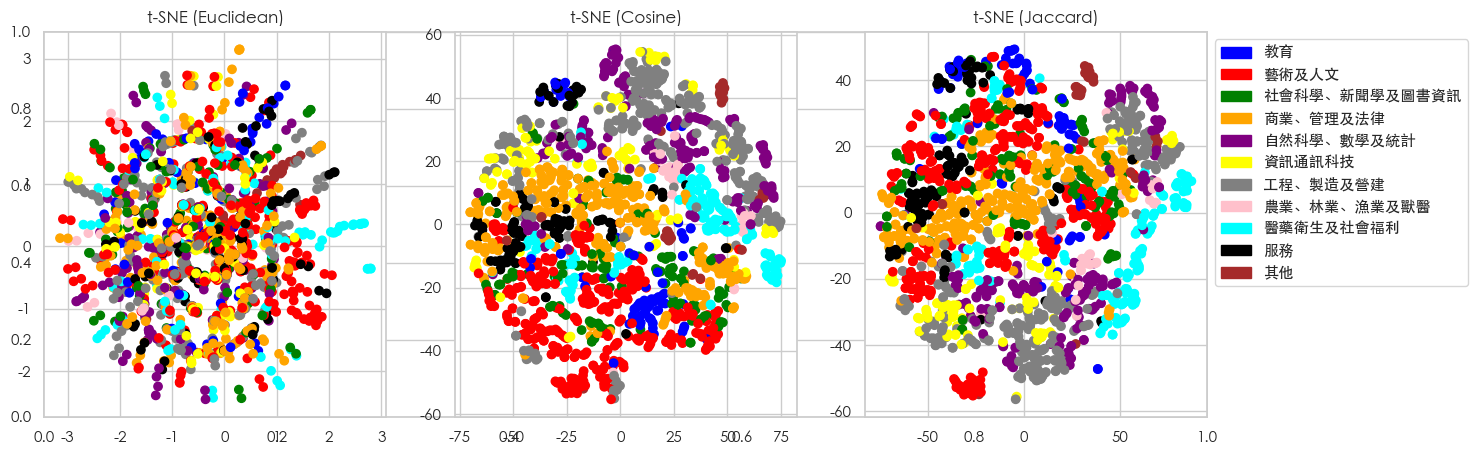

In [114]:
# Plot the embedded data for each metric
plt.figure(figsize=(15, 5))
legend_labels = []
for category_id, color in colors.items():
    legend_labels.append(mpatches.Patch(color=color, label=category_to_name[category_id]))
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(131)
plt.scatter(embedded_data_tsne_euclidean[:, 0], embedded_data_tsne_euclidean[:, 1], color = clr)
plt.title('t-SNE (Euclidean)')

plt.subplot(132)
plt.scatter(embedded_data_tsne_cosine[:, 0], embedded_data_tsne_cosine[:, 1], color = clr)
plt.title('t-SNE (Cosine)')

plt.subplot(133)
plt.scatter(embedded_data_tsne_jaccard[:, 0], embedded_data_tsne_jaccard[:, 1], color = clr)
plt.title('t-SNE (Jaccard)')



plt.show()

We can see that t-SNE did a really good job as grouping different data, we can see same department all group together.

Moreover, we can easily see some department which has same target student group.

Like the 理工科系 are grouped together, and 文組科系 are also grouped together.

醫學科系 are pretty much alone, sharing different target students compare to other departments.

### Q2.6 Select the most promising visualization method in the previous question and refine the result.

I use t-SNE for the final representation, and I use seaborn to plot.

It prevents points overlapping each other, and it can make different category with differnt shapes of points.

In [115]:
from sklearn.manifold import TSNE

# Jaccard distance (assuming 'data' is binary)
tsne_jaccard = TSNE(n_components=2, metric='jaccard', random_state=42)
embedded_data_tsne_jaccard = tsne_jaccard.fit_transform(data)


/Users/yl/Library/Caches/pypoetry/virtualenvs/slml-JC0Nopl2-py3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/var/folders/l8/cns8rbyx5y17d2vn6gf6qkk80000gn/T/ipykernel_57013/3659210091.py:12: UserWarning: 
The markers list has fewer values (3) than needed (11) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(x=embedded_data_tsne_jaccard[:, 0], y=embedded_data_tsne_jaccard[:, 1], hue=clr, style=clr, markers=["o", "s", "D"])


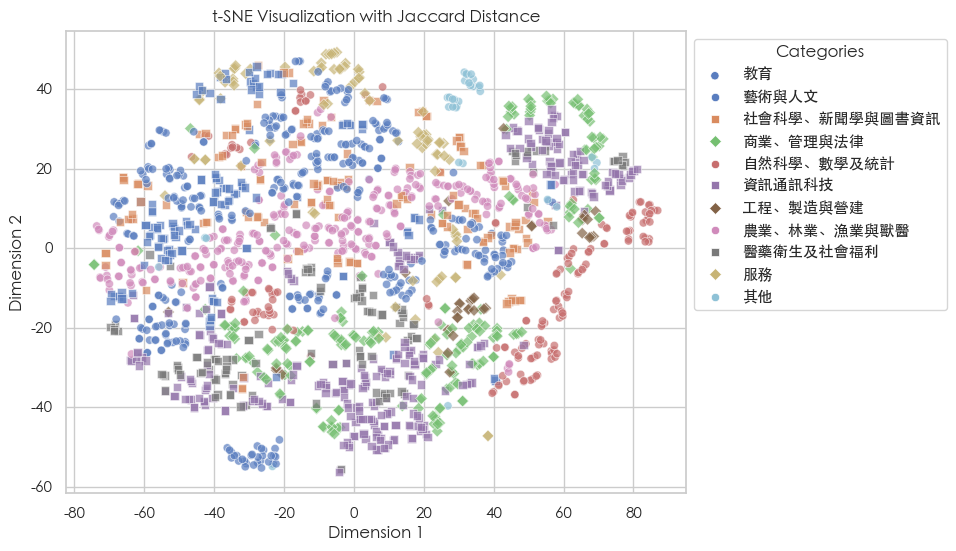

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Set up Seaborn style
category = ["教育", "藝術與人文", "社會科學、新聞學與圖書資訊", "商業、管理與法律", "自然科學、數學及統計", "資訊通訊科技", "工程、製造與營建", "農業、林業、漁業與獸醫", "醫藥衛生及社會福利", "服務", "其他"]
sns.set(style="whitegrid", palette=sns.color_palette("muted", n_colors=len(category), desat=0.75), font="STHeiti")

# Plot the embedded data with Jaccard using Seaborn
plt.figure(figsize=(8, 6))

scatter = sns.scatterplot(x=embedded_data_tsne_jaccard[:, 0], y=embedded_data_tsne_jaccard[:, 1], hue=clr, style=clr, markers=["o", "s", "D"])

scatter.legend(category, title='Categories', loc='upper left', bbox_to_anchor=(1, 1))
scatter.collections[0].set_alpha(0.7)


plt.title('t-SNE Visualization with Jaccard Distance')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.savefig('tsne_jaccard_visualization.png', bbox_inches='tight')

plt.show()

We can see that t-SNE did a really good job as grouping different data, we can see same department all group together.

Moreover, we can easily see some department which has same target student group.

First, the gray, purple, yellow dots are mostly stack on top of each other. We can see that their target students are mostly the same.

Those three colors represent 資訊、工程製造、自然科學數學 these are all 理工科系, hence sharing same target students.

Secondly we can see blue, green, black, red are stacking each other as well.

They are 教育、藝術、社會科學、服務, which are all 一類組 hence sharing same target students.

However, for 藝術 there is a group of red point on the bottom left corner, indicating those are specificially for art department.

For orange and blue dots aren't on top other, meaning they are mostly on there own, don't share same student group with other departments.

They stand for 商業管理法律、醫學系.